In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os
from time import time

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities_NOMXNET import *
from annotation_utilities import *

/Users/kuiqian/Github/MouseBrainAtlas_dev/src//utilities/utilities2015.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/kuiqian/Github/venv/mousebrainatlas_virtualenv/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/kuiqian/Github/venv/mousebrainatlas_virtualenv/lib/python2.7/site-packages/

Setting environment for an unknown machine. Global root paths must be set as env variables.
{'MD589': 0.46}
Loaded data from saved metadata_cache for MD589


No vtk
No mcubes
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD585 anchor: ini file /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/operation_configs/from_none_to_aligned.ini does not exist.
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD585 section_limits: ini file /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/operation_configs/from_none_to_aligned.ini does not exist.
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to load operation ini.
Failed to cache MD585 cropbox: ini file /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/operation_configs/from_none_to_aligned.ini does not exist.
Failed to cache MD585 valid_sections/filenames: MD585
No anchor.txt is found. Seems we are using the operation ini to provide anchor. Try to

In [2]:
stack = 'MD589'

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

images_root = ROOT_DIR+'/CSHL_data_processed/'+stack+'/'+stack+'_prep2_thumbnail/'
raw_images_root = ROOT_DIR+'/CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'

image_fn_list = ! ls $images_root
raw_image_fn_list = ! ls $raw_images_root

filename_to_section, section_to_filename = DataManager.load_sorted_filenames( stack )

In [3]:
local_fp, latest_timestamp = DataManager.get_annotation_filepath(stack, by_human=True, suffix='contours', \
            timestamp='latest', return_timestamp=True, annotation_rootdir=ANNOTATION_ROOTDIR, download_s3=False)
annotation= load_hdf_v2(local_fp)

latest timestamp:  05312018031718


In [4]:
prep_id = 2
contours = annotation[(annotation['orientation'] == 'sagittal') & (annotation['resolution'] == 'raw')]
contours = contours.drop_duplicates(subset=['section', 'name', 'side', 'filename', 'resolution', 'creator'])

In [5]:
contours_grouped = contours.groupby('name')
for struc, cnt_group in contours_grouped:
    polygons = [(contour['section'], contour['vertices']) for contour_id, contour in cnt_group.iterrows()]

In [10]:
section = 218
polygons = [(contour['section'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group('SC').iterrows() ]
for contour_id, contour in polygons:
    if contour_id==section:
        polygon = contour

In [3]:
margin_um = 200
margin = margin_um / XY_PIXEL_DISTANCE_LOSSLESS
103.04/XY_PIXEL_DISTANCE_LOSSLESS, 30/XY_PIXEL_DISTANCE_LOSSLESS

(224.0, 65.21739130434783)

In [12]:
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif' , 2)
m, n = img.shape

In [13]:
path = Path(polygon)
bbox = path.get_extents()

In [14]:
[left, right, up, down] = [int(bbox.xmin), 
                           int(np.ceil(bbox.xmax)),
                           int(bbox.ymin), 
                           int(np.ceil(bbox.ymax))]
print(left, right, up, down)

(2659, 7321, 753, 3363)


In [15]:
center = ((bbox.xmin+bbox.xmax)/2, (bbox.ymin+bbox.ymax)/2)
radius = np.sqrt((bbox.xmax-center[0])**2+(bbox.ymax-center[1])**2)+margin
circle = Path.circle(center, radius)
bbox = circle.get_extents()

In [16]:
[cleft, cright, cup, cdown] = [int(max(bbox.xmin,0)), 
                           int(min(np.ceil(bbox.xmax),n-1)),
                           int(max(bbox.ymin,0)), 
                           int(min(np.ceil(bbox.ymax),m-1))]
print(cleft, cright, cup, cdown)

(1884, 8096, 0, 5164)


In [17]:
t0 = time.time()
xs, ys = np.meshgrid(np.arange(cleft, cright+1), np.arange(cup, cdown+1), indexing='xy')
locations = np.c_[xs.flat, ys.flat]
print(time.time()-t0)

0.65567111969


11.9647960663
14.8381440639


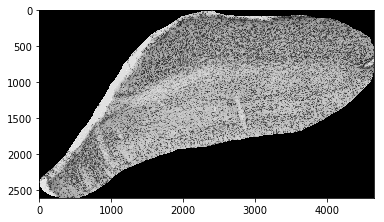

In [18]:
t0 = time.time()
indices_inside = np.where(path.contains_points(locations))[0]
indices_in = locations[indices_inside]
print(time.time()-t0)
x_raw =indices_in[:,0]-left
y_raw =indices_in[:,1]-up
mask = np.zeros((down-up+1, right-left+1))
for i in range(len(indices_in)):
    mask[y_raw[i],x_raw[i]]=1
mask=mask.astype(np.uint8)
print(time.time()-t0)
patch = img[up:down+1,left:right+1]*mask
plt.imshow( patch, cmap='gray')

33.9192488194
36.8197879791
46.1471838951


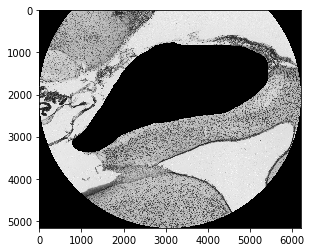

In [19]:
t0 = time.time()
indices_sur = np.where(circle.contains_points(locations))[0]
print(time.time()-t0)
indices_outside = np.setdiff1d(indices_sur, indices_inside)
indices_out = locations[indices_outside]
print(time.time()-t0)
x_raw =indices_out[:,0]-cleft
y_raw =indices_out[:,1]-cup
mask = np.zeros((cdown-cup+1, cright-cleft+1))
for i in range(len(indices_out)):
    mask[y_raw[i],x_raw[i]]=1
mask=mask.astype(np.uint8)
print(time.time()-t0)
patch = img[cup:cdown+1,cleft:cright+1]*mask
plt.imshow( patch, cmap='gray')

In [20]:
# Regions
t0 = time.time()
margin_um = 200
margin = margin_um / XY_PIXEL_DISTANCE_LOSSLESS
! mkdir $ROOT_DIR/CSHL_new_regions
! mkdir $ROOT_DIR/CSHL_new_regions/$stack
for structure in all_structures:
    t1 = time.time()
    posi_path = ROOT_DIR+'/CSHL_new_regions/'+stack+'/'+structure
    nega_path = posi_path+'_surround_200um_noclass'
    if os.path.exists(posi_path):
        print(structure+' ALREADY EXIST')
        continue
    else:
        ! mkdir $posi_path
        ! mkdir $nega_path
    
    polygons = [(contour['section'], contour['vertices']) \
                for contour_id, contour in contours_grouped.get_group(structure).iterrows() ]
    
    for contour_id, contour in polygons:
        section = contour_id
        polygon = contour
        img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif' , 2)
        m, n = img.shape
        path = Path(polygon)
        bbox = path.get_extents()
        [left, right, up, down] = [int(bbox.xmin), 
                                   int(np.ceil(bbox.xmax)),
                                   int(bbox.ymin), 
                                   int(np.ceil(bbox.ymax))]
        center = ((bbox.xmin+bbox.xmax)/2, (bbox.ymin+bbox.ymax)/2)
        radius = np.sqrt((bbox.xmax-center[0])**2+(bbox.ymax-center[1])**2)+margin
        circle = Path.circle(center, radius)
        bbox = circle.get_extents()
        [cleft, cright, cup, cdown] = [int(max(bbox.xmin,0)), 
                                       int(min(np.ceil(bbox.xmax),n-1)),
                                       int(max(bbox.ymin,0)), 
                                       int(min(np.ceil(bbox.ymax),m-1))]
        xs, ys = np.meshgrid(np.arange(cleft, cright+1), np.arange(cup, cdown+1), indexing='xy')
        locations = np.c_[xs.flat, ys.flat]
        # Foreground
        indices_inside = np.where(path.contains_points(locations))[0]
        indices_in = locations[indices_inside]
        x_raw =indices_in[:,0]-left
        y_raw =indices_in[:,1]-up
        mask = np.zeros((down-up+1, right-left+1))
        for i in range(len(indices_in)):
            mask[y_raw[i],x_raw[i]]=1
        mask=mask.astype(np.uint8)
        patch = img[up:down+1,left:right+1]*mask
        filename=posi_path+'/'+str(section)+'.tif'
        cv2.imwrite(filename, patch)
        
        # Background
        indices_sur = np.where(circle.contains_points(locations))[0]
        indices_outside = np.setdiff1d(indices_sur, indices_inside)
        indices_out = locations[indices_outside]
        x_raw =indices_out[:,0]-cleft
        y_raw =indices_out[:,1]-cup
        mask = np.zeros((cdown-cup+1, cright-cleft+1))
        for i in range(len(indices_out)):
            mask[y_raw[i],x_raw[i]]=1
        mask=mask.astype(np.uint8)
        patch = img[cup:cdown+1,cleft:cright+1]*mask
        filename=nega_path+'/'+str(section)+'.tif'
        cv2.imwrite(filename, patch)
    print(structure + ' finished in %5.1f seconds' % (time.time() - t1))
print('Finished in %5.1f seconds' % (time.time() - t0))

5N finished in 415.4 seconds
6N finished in  20.0 seconds
7N finished in 796.7 seconds
7n ALREADY EXIST
Amb finished in  67.0 seconds
LC finished in 207.5 seconds
LRt finished in 718.1 seconds
Pn finished in 1307.8 seconds
Tz finished in 425.9 seconds
VLL finished in 697.9 seconds
RMC finished in 415.1 seconds
SNC finished in 548.7 seconds
SNR finished in 1996.3 seconds
3N finished in 150.2 seconds
4N finished in  37.9 seconds
Sp5I finished in 965.4 seconds
Sp5O finished in 1398.5 seconds
Sp5C finished in 2472.5 seconds
PBG finished in 123.0 seconds
10N finished in 324.0 seconds
VCA finished in 734.0 seconds
VCP finished in 411.9 seconds
DC finished in 906.3 seconds
AP finished in  90.7 seconds
12N finished in 468.5 seconds
RtTg finished in 159.6 seconds
SC finished in 7313.1 seconds
IC finished in 4032.3 seconds
Finished in 27204.8 seconds


In [25]:
s3_fp = 's3://mousebrainatlas-data/'+'CSHL_new_regions/'+stack
local_fp = os.environ['ROOT_DIR']+'/CSHL_new_regions/'+stack
! aws s3 cp --recursive $local_fp $s3_fp

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/10N/200.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/10N/200.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/10N/208.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/10N/208.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/10N/212.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/10N/212.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/10N/211.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/10N/211.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/10N/201.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/10N/201.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/10N/213.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/10N/213.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/10N/215.tif to s3:/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/12N/210.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/12N/210.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/12N/211.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/12N/211.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/12N/214.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/12N/214.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/10N_surround_200um_noclass/245.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/10N_surround_200um_noclass/245.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/12N/212.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/12N/212.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/12N/209.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/12N/209.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_br

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/12N_surround_200um_noclass/218.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/12N_surround_200um_noclass/218.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/12N_surround_200um_noclass/220.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/12N_surround_200um_noclass/220.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/12N_surround_200um_noclass/215.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/12N_surround_200um_noclass/215.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/12N_surround_200um_noclass/224.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/12N_surround_200um_noclass/224.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/12N_surround_200um_noclass/225.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/12N_surround_200um_noclass/225.tif
upload: ../../.

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/4N_surround_200um_noclass/237.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/4N_surround_200um_noclass/237.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/4N_surround_200um_noclass/240.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/4N_surround_200um_noclass/240.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/4N_surround_200um_noclass/238.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/4N_surround_200um_noclass/238.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/4N_surround_200um_noclass/239.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/4N_surround_200um_noclass/239.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/4N_surround_200um_noclass/234.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/4N_surround_200um_noclass/234.tif
upload: ../../../../Bstem

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/5N_surround_200um_noclass/309.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/5N_surround_200um_noclass/309.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/6N_surround_200um_noclass/205.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/6N_surround_200um_noclass/205.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/7N/152.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/7N/152.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/6N_surround_200um_noclass/214.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/6N_surround_200um_noclass/214.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/7N/153.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/7N/153.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/6N_surround_200um_noclass/251.tif to s3://

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/7N_surround_200um_noclass/159.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/7N_surround_200um_noclass/159.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/7N_surround_200um_noclass/162.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/7N_surround_200um_noclass/162.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/7N_surround_200um_noclass/160.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/7N_surround_200um_noclass/160.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/7N_surround_200um_noclass/164.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/7N_surround_200um_noclass/164.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/7N_surround_200um_noclass/166.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/7N_surround_200um_noclass/166.tif
upload: ../../../../Bstem

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/AP/222.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/AP/222.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/AP/223.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/AP/223.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/AP/227.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/AP/227.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/AP/225.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/AP/225.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/AP/229.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/AP/229.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/AP/228.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/AP/228.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/7N_surround_200um_noclass/312.t

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/152.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/152.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/153.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/153.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/154.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/154.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/156.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/156.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/155.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/155.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/158.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/158.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/157.tif to s3://mousebrainat

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/343.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/343.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/346.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/346.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/355.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/355.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/354.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/354.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/344.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/344.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/352.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC/352.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC/353.tif to s3://mousebrainat

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC_surround_200um_noclass/319.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC_surround_200um_noclass/319.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC_surround_200um_noclass/311.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC_surround_200um_noclass/311.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC_surround_200um_noclass/322.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC_surround_200um_noclass/322.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC_surround_200um_noclass/325.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC_surround_200um_noclass/325.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/DC_surround_200um_noclass/327.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/DC_surround_200um_noclass/327.tif
upload: ../../../../Bstem

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/187.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/187.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/189.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/189.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/194.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/194.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/188.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/188.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/196.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/196.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/193.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/193.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/195.tif to s3://mousebrainat

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/242.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/242.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/249.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/249.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/246.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/246.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/241.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/241.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/247.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/247.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/251.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/251.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/245.tif to s3://mousebrainat

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/297.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/297.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/303.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/303.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/296.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/296.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/298.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/298.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/309.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/309.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/308.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC/308.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC/311.tif to s3://mousebrainat

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC_surround_200um_noclass/154.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC_surround_200um_noclass/154.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC_surround_200um_noclass/153.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC_surround_200um_noclass/153.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC_surround_200um_noclass/152.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC_surround_200um_noclass/152.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC_surround_200um_noclass/156.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC_surround_200um_noclass/156.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC_surround_200um_noclass/159.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC_surround_200um_noclass/159.tif
upload: ../../../../Bstem

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC_surround_200um_noclass/241.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC_surround_200um_noclass/241.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC_surround_200um_noclass/239.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC_surround_200um_noclass/239.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC_surround_200um_noclass/237.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC_surround_200um_noclass/237.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC_surround_200um_noclass/238.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC_surround_200um_noclass/238.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC_surround_200um_noclass/243.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC_surround_200um_noclass/243.tif
upload: ../../../../Bstem

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/IC_surround_200um_noclass/314.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/IC_surround_200um_noclass/314.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LC/267.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LC/267.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LC/270.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LC/270.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LC/268.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LC/268.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LC/269.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LC/269.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LC/266.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LC/266.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt/164.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt/164.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LC_surround_200um_noclass/267.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LC_surround_200um_noclass/267.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LC_surround_200um_noclass/269.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LC_surround_200um_noclass/269.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt/166.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt/166.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt/169.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt/169.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt/168.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt/168.tif
upload

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt/295.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt/295.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt/301.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt/301.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt/306.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt/306.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt/302.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt/302.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt/294.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt/294.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt/303.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt/303.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt/307.tif to s3:/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt_surround_200um_noclass/189.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt_surround_200um_noclass/189.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt_surround_200um_noclass/184.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt_surround_200um_noclass/184.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt_surround_200um_noclass/185.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt_surround_200um_noclass/185.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt_surround_200um_noclass/188.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt_surround_200um_noclass/188.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt_surround_200um_noclass/190.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt_surround_200um_noclass/190.tif
upload: ../../.

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/PBG/126.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/PBG/126.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/PBG/128.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/PBG/128.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/PBG/129.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/PBG/129.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/LRt_surround_200um_noclass/305.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/LRt_surround_200um_noclass/305.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/PBG/130.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/PBG/130.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/PBG/131.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/PBG/131.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_br

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/PBG_surround_200um_noclass/314.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/PBG_surround_200um_noclass/314.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/PBG_surround_200um_noclass/135.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/PBG_surround_200um_noclass/135.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn/177.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn/177.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn/178.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn/178.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn/179.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn/179.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/PBG_surround_200um_noclass/316.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD5

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn_surround_200um_noclass/175.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn_surround_200um_noclass/175.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn_surround_200um_noclass/178.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn_surround_200um_noclass/178.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn_surround_200um_noclass/177.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn_surround_200um_noclass/177.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn_surround_200um_noclass/179.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn_surround_200um_noclass/179.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn_surround_200um_noclass/176.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn_surround_200um_noclass/176.tif
upload: ../../../../Bstem

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn_surround_200um_noclass/271.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn_surround_200um_noclass/271.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn_surround_200um_noclass/284.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn_surround_200um_noclass/284.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn_surround_200um_noclass/280.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn_surround_200um_noclass/280.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn_surround_200um_noclass/283.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn_surround_200um_noclass/283.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn_surround_200um_noclass/285.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn_surround_200um_noclass/285.tif
upload: ../../../../Bstem

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC/212.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC/212.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC/250.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC/250.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC/251.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC/251.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC/248.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC/248.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Pn_surround_200um_noclass/289.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Pn_surround_200um_noclass/289.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC/253.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC/253.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brai

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC_surround_200um_noclass/214.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC_surround_200um_noclass/214.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC_surround_200um_noclass/238.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC_surround_200um_noclass/238.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC_surround_200um_noclass/207.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC_surround_200um_noclass/207.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC_surround_200um_noclass/239.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC_surround_200um_noclass/239.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC_surround_200um_noclass/241.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC_surround_200um_noclass/241.tif
upload: ../../.

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC_surround_200um_noclass/266.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC_surround_200um_noclass/266.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC_surround_200um_noclass/267.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC_surround_200um_noclass/267.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RMC_surround_200um_noclass/262.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RMC_surround_200um_noclass/262.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RtTg_surround_200um_noclass/220.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RtTg_surround_200um_noclass/220.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/RtTg/268.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/RtTg/268.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/161.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/161.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/151.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/151.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/153.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/153.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/164.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/164.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/159.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/159.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/163.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/163.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/165.tif to s3://mousebrainat

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/216.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/216.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/212.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/212.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/211.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/211.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/215.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/215.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/217.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/217.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/219.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/219.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/218.tif to s3://mousebrainat

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/268.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/268.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/272.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/272.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/276.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/276.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/269.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/269.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/275.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/275.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/271.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC/271.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC/274.tif to s3://mousebrainat

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/138.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/138.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/139.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/139.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/140.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/140.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/141.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/141.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/142.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/142.tif
upload: ../../../../Bstem

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/224.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/224.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/225.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/225.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/222.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/222.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/227.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/227.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/228.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/228.tif
upload: ../../../../Bstem

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/311.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/311.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC/149.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC/149.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/309.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/309.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC/150.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC/150.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SC_surround_200um_noclass/308.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SC_surround_200um_noclass/308.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC/154.tif to s3://mousebrainatlas-da

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC_surround_200um_noclass/159.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC_surround_200um_noclass/159.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC_surround_200um_noclass/165.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC_surround_200um_noclass/165.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC_surround_200um_noclass/166.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC_surround_200um_noclass/166.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC_surround_200um_noclass/168.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC_surround_200um_noclass/168.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC_surround_200um_noclass/163.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC_surround_200um_noclass/163.tif
upload: ../../.

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC_surround_200um_noclass/290.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC_surround_200um_noclass/290.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC_surround_200um_noclass/284.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC_surround_200um_noclass/284.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC_surround_200um_noclass/283.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC_surround_200um_noclass/283.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC_surround_200um_noclass/287.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC_surround_200um_noclass/287.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNC_surround_200um_noclass/292.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNC_surround_200um_noclass/292.tif
upload: ../../.

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR/153.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR/153.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR/145.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR/145.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR/151.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR/151.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR/148.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR/148.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR/152.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR/152.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR/147.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR/147.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR/155.tif to s3:/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/130.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/130.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/129.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/129.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/131.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/131.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/133.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/133.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/132.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/132.tif
upload: ../../.

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/173.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/173.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/171.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/171.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/169.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/169.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/174.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/174.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/176.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/176.tif
upload: ../../.

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/288.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/288.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/286.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/286.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/287.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/287.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/289.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/289.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/SNR_surround_200um_noclass/291.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/SNR_surround_200um_noclass/291.tif
upload: ../../.

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C/182.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C/182.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C/185.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C/185.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C/186.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C/186.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C/179.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C/179.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C/190.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C/190.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C/187.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C/187.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C/19

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/142.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/142.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/143.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/143.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/144.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/144.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/148.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/148.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/145.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/145.tif
uploa

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/282.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/282.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/279.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/279.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/286.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/286.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/287.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/287.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/288.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5C_surround_200um_noclass/288.tif
uploa

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I/318.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5I/318.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I/320.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5I/320.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I/322.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5I/322.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I/317.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5I/317.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I/315.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5I/315.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I/323.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5I/323.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I/32

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I_surround_200um_noclass/143.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5I_surround_200um_noclass/143.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I_surround_200um_noclass/141.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5I_surround_200um_noclass/141.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I_surround_200um_noclass/147.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5I_surround_200um_noclass/147.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I_surround_200um_noclass/148.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5I_surround_200um_noclass/148.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5I_surround_200um_noclass/145.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5I_surround_200um_noclass/145.tif
uploa

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/119.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/119.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/120.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/120.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/122.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/122.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/123.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/123.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/124.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/124.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/126.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/126.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/12

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/318.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/318.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/151.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/151.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/313.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/313.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/320.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/320.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/321.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/321.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/322.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O/322.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O/31

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz/204.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz/204.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O_surround_200um_noclass/332.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O_surround_200um_noclass/332.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz/206.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz/206.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O_surround_200um_noclass/326.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O_surround_200um_noclass/326.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz/208.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz/208.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O_surround_200um_noclass/335.tif to s3://mousebrainatlas-data/CSHL_new_region

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz_surround_200um_noclass/202.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz_surround_200um_noclass/202.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Sp5O_surround_200um_noclass/330.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Sp5O_surround_200um_noclass/330.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz_surround_200um_noclass/206.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz_surround_200um_noclass/206.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz_surround_200um_noclass/207.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz_surround_200um_noclass/207.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz_surround_200um_noclass/209.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz_surround_200um_noclass/209.tif
upload: ../../../../B

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz_surround_200um_noclass/267.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz_surround_200um_noclass/267.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz_surround_200um_noclass/269.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz_surround_200um_noclass/269.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz_surround_200um_noclass/264.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz_surround_200um_noclass/264.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz_surround_200um_noclass/270.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz_surround_200um_noclass/270.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/Tz_surround_200um_noclass/275.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/Tz_surround_200um_noclass/275.tif
upload: ../../../../Bstem

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCA/359.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCA/359.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCA/362.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCA/362.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCA/345.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCA/345.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCA/367.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCA/367.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCA/366.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCA/366.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCA/364.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCA/364.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCA/94.tif to s3://

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP/111.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCP/111.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP/108.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCP/108.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP/112.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCP/112.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP/113.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCP/113.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP/109.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCP/109.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP/121.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCP/121.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP/115.tif to s3:/

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP_surround_200um_noclass/116.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCP_surround_200um_noclass/116.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP_surround_200um_noclass/110.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCP_surround_200um_noclass/110.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP_surround_200um_noclass/113.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCP_surround_200um_noclass/113.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP_surround_200um_noclass/109.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCP_surround_200um_noclass/109.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VCP_surround_200um_noclass/115.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VCP_surround_200um_noclass/115.tif
upload: ../../.

upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VLL/298.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VLL/298.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VLL/308.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VLL/308.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VLL/312.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VLL/312.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VLL/310.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VLL/310.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VLL/313.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VLL/313.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VLL/317.tif to s3://mousebrainatlas-data/CSHL_new_regions/MD589/VLL/317.tif
upload: ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_new_regions/MD589/VLL/314.tif to s3:/

In [24]:
! find $local_fp -type f | wc -l

    3590


In [27]:
section_to_filename[218]

'MD589-N41-2015.07.30-18.48.44_MD589_1_0121'